In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 6.3 MB/s eta 0:00:00


In [2]:
import copy
import os    
from scipy import interpolate
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import torch.cuda
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import surrogate


os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device('cuda')


data_path = '/kaggle/input/polymer-data'
size = [6, 8, 10, 12]
data_num = [64, 256, 1024, 4096]
split = 2500  # 训练的数据数量
sequence = []
average_continuous_length = []

ratio = 10000
beta = 0.95 # 衰减率
thr = 1
num_steps = 25
num_hidden = 25
num_epochs = 10


batch_size = 8
dtype = torch.float


In [3]:
# 创建数据集对象
class MyDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        seq = self.data[item][:20]
        features = self.data[item][20:]

        return seq.clone().detach(), features.clone().detach()


class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, num_out):
        super().__init__()
        
        self.num_out = num_out
        self.timesteps = num_steps # 模拟网络的时间步长数
        self.hidden = num_hidden # 隐藏神经元的数量
        spike_grad = snn.surrogate.fast_sigmoid() # 代理梯度函数，用于近似脉冲发放函数的梯度

        # 第一层：全连接层 + LIF神经元
        self.fc_in = torch.nn.Linear(in_features=20, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, threshold=thr, spike_grad=spike_grad)

        # 第二层：全连接层 + LIF神经元
        self.fc_hidden = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif_hidden = snn.Leaky(beta=beta, threshold=thr, spike_grad=spike_grad)

        # 第三层：全连接层 + 泄漏积分器神经元
        # 注意：重置机制已禁用，输出脉冲将被忽略
        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=self.num_out)
        self.li_out = snn.Leaky(beta=beta, threshold=thr, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """多时间步的前向传播。"""

        # 初始化膜电位
        mem_1 = self.lif_in.init_leaky().to(device)
        mem_2 = self.lif_hidden.init_leaky().to(device)
        mem_3 = self.li_out.init_leaky().to(device)

        # 记录输出的空列表
        mem_3_rec = []

        # 迭代时间步
        for step in range(self.timesteps):
            # 第一层前向传播
            cur_in = self.fc_in(x)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            # 第二层前向传播
            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            # 第三层前向传播
            cur_out = self.fc_out(spk_hidden)
            _, mem_3 = self.li_out(cur_out, mem_3)

            # 记录第三层的膜电位
            mem_3_rec.append(mem_3)

        # 返回记录的膜电位
        return torch.stack(mem_3_rec)

    
# k折叠划分数据集
def split_dataset(dataset):
    # 将数据集划分为 k 个折叠
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_results = []
    for train_index, test_index in kfold.split(dataset):
        # 划分训练集和验证集
        train_data = [dataset[i] for i in train_index]
        test_data = [dataset[i] for i in test_index]

    return train_data, test_data


# 计算序列的平均碎片长度
def calculate_average_continuous_length(sequence):
    continuous_lengths = []
    current_length = 1
    
    for i in range(1, len(sequence)):
        if sequence[i] == sequence[i - 1]:
            current_length += 1
        else:
            continuous_lengths.append(current_length)
            current_length = 1
    
    continuous_lengths.append(current_length)
    
    return np.mean(continuous_lengths)


# 填充数据缺失
def smooth_zeros_with_linear_interp(data):
    indices = np.arange(len(data))
    non_zero_indices = indices[data != 0]
    zero_indices = indices[data == 0]
    
    f = interpolate.interp1d(non_zero_indices, data[data != 0], kind='slinear', bounds_error=False, fill_value=0)
    data[zero_indices] = f(zero_indices)
    
    return data

In [4]:
import random

# 加载数据
for i in range(4):
    temp_path = os.path.join(data_path, str(size[i]))
    seq_file = os.path.join(temp_path, 'sq.txt')
    with open(seq_file, 'r') as f:
        line = f.readline().split(' ')[:-1]
        line = [eval(i) for i in line]
        while line:
            avg_conti = calculate_average_continuous_length(line)
            average_continuous_length.append(avg_conti)
            line.extend([0.5] * (20 - len(line)))
            sequence.append(line)
            line = f.readline().split(" ")[:-1]
            line = [eval(i) for i in line]

f_data = copy.deepcopy(sequence)
u_data = copy.deepcopy(sequence)
str_data = copy.deepcopy(sequence)

data_idx = 0
for i in range(4):
    temp_path = os.path.join(data_path, str(size[i]))
    for j in range(1, data_num[i] + 1):
        energy_file = os.path.join(temp_path, 'FU_' + str(j) + '.txt')
        with open(energy_file, 'r') as f:
            for line in f:
                columns = line.split()
                column1 = columns[0]
                column2 = columns[1]
                f_data[data_idx].append(eval(column1))
                u_data[data_idx].append(eval(column2))
        data_idx += 1
        
data_idx = 0
for i in range(4):
    temp_path = os.path.join(data_path, str(size[i]))
    for j in range(1, data_num[i] + 1):
        str_file = os.path.join(temp_path, 'Structure_' + str(j) + '.txt')
        with open(str_file, 'r') as f:
            for line in f:
                # 去除每行末尾的换行符并按照空格分割数据
                data = line.strip().split()
                num_list = [float(x) for x in data]
                # 将数据添加到列表中
                str_data[data_idx].append(ratio * sum(num_list))
        smoothed_data = smooth_zeros_with_linear_interp(np.array(str_data[data_idx][20:]))
        str_data[data_idx][20:] = smoothed_data
        # str_data[data_idx][20:] = [x if x >= 0 else 0 for x in smoothed_data]
        data_idx += 1
        
start_idx = 64 + 256 + 1024  # 获取 size[3] 的起始索引
end_idx = start_idx + 4096  # 获取 size[3] 的结束索引

# 打乱 f_data, u_data, 和 str_data 中 size[3] 的数据
combined = list(zip(f_data[start_idx:end_idx], u_data[start_idx:end_idx], str_data[start_idx:end_idx], sequence[start_idx:end_idx]))
random.shuffle(combined)
f_data[start_idx:end_idx], u_data[start_idx:end_idx], str_data[start_idx:end_idx], sequence[start_idx:end_idx] = zip(*combined)


# 将数据都转换成float
f_train = [torch.tensor([float(item) for item in line]) for line in f_data[:split]]
f_test = [torch.tensor([float(item) for item in line]) for line in f_data[split:]]
u_train = [torch.tensor([float(item) for item in line]) for line in u_data[:split]]
u_test = [torch.tensor([float(item) for item in line]) for line in u_data[split:]]
str_train = [torch.tensor([float(item) for item in line]) for line in str_data[:split]]
str_test = [torch.tensor([float(item) for item in line]) for line in str_data[split:]]
f_dataset = MyDataset(f_train)
u_dataset = MyDataset(u_train)
str_dataset = MyDataset(str_train)

In [5]:
"""
初始化网络和优化器:网络结构被定义为 Net 类，并加载到设备（CPU 或 GPU）上。
优化器选择了 Adam 优化器。
"""


# 外部训练循环
def train(dataset, tag, model, lr=0.001, betas=(0.9, 0.999)):
    # 记录训练和测试损失的列表
    loss_hist = []
    test_loss_hist = []

    model = model.to(device)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr, betas)
    
    print(f'training on {device}------')
    
    for epoch in range(num_epochs):
        # 划分数据集
        train_dataset, test_dataset = split_dataset(dataset=dataset)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

        iter_counter = 0
        train_batch = iter(train_dataloader)

        # 内部训练循环
        for seq, target in train_batch:
            seq = seq.to(device)
            target = target.to(device)

            # 向前传播
            model.train()
            mem_rec = model(seq).to(device)

            # 初始化损失并进行时间步长的累加
            loss_val = torch.zeros((1), dtype=dtype)
            loss_val = loss_val.to(device)
            loss_val += loss(mem_rec[-1].to(device), target)

            # 梯度计算 + 权重更新
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # 记录训练损失
            loss_hist.append(loss_val.item())

            # 在每个迭代的末尾，使用测试集计算损失和准确率
            if iter_counter % 50 == 0:
                with torch.no_grad():
                    model.eval()
                    test_seq, test_targets = next(iter(test_dataloader))
                    test_seq = test_seq.to(device)
                    test_targets = test_targets.to(device)

                    # 测试集前向传播
                    test_mem = model(test_seq)

                    # 计算测试损失
                    test_loss = torch.zeros((1), dtype=dtype, device=device)
                    test_loss += loss(test_mem[-1].to(device), test_targets)
                    test_loss_hist.append(test_loss.item())

                # 打印训练信息
                print(f'------Epoch {epoch+1}, Iteration {iter_counter}------')
                print(f'------Loss of {tag} 为：{test_loss.item()}------')
            iter_counter += 1
    torch.save(model.state_dict(), '/kaggle/working/pred_' + tag + '.pth')
    return loss_hist, test_loss_hist


training on cuda------
------Epoch 1, Iteration 0------
------Loss of F 为：41.011348724365234------
------Epoch 1, Iteration 50------
------Loss of F 为：7.568099021911621------
------Epoch 1, Iteration 100------
------Loss of F 为：0.886486291885376------
------Epoch 1, Iteration 150------
------Loss of F 为：0.7333617210388184------
------Epoch 1, Iteration 200------
------Loss of F 为：1.4107918739318848------
------Epoch 2, Iteration 0------
------Loss of F 为：1.8406943082809448------
------Epoch 2, Iteration 50------
------Loss of F 为：0.5173057913780212------
------Epoch 2, Iteration 100------
------Loss of F 为：0.6939775347709656------
------Epoch 2, Iteration 150------
------Loss of F 为：0.4569563865661621------
------Epoch 2, Iteration 200------
------Loss of F 为：0.36340877413749695------
------Epoch 3, Iteration 0------
------Loss of F 为：0.5958713889122009------
------Epoch 3, Iteration 50------
------Loss of F 为：0.65364670753479------
------Epoch 3, Iteration 100------
------Loss of F 为：

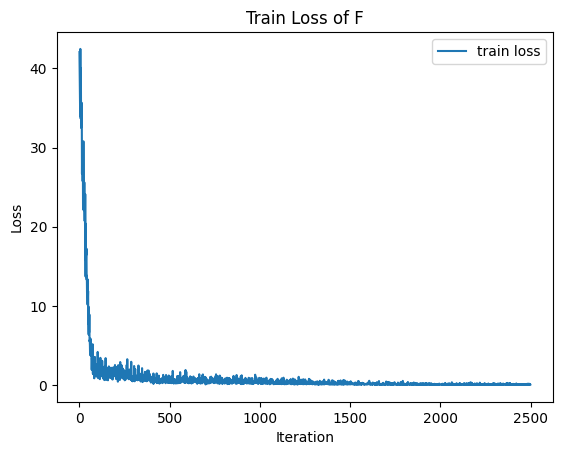

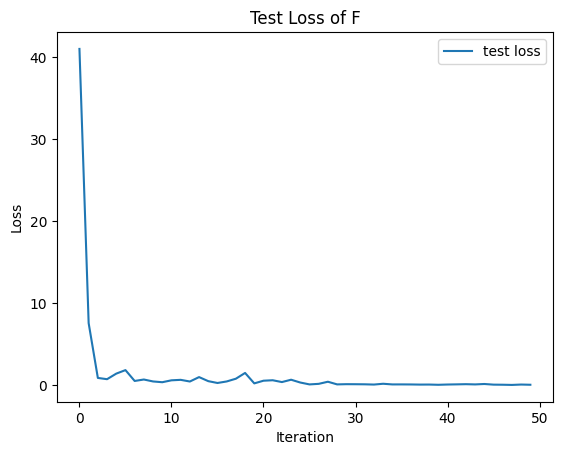

In [6]:
f_net = Net(48)
f_loss_hist, f_test_loss_hist = train(f_dataset, 'F', f_net)

plt.plot(f_loss_hist,label='train loss')
plt.title("Train Loss of F")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('/kaggle/working/f_train_loss.png')
plt.show()

plt.plot(f_test_loss_hist,label='test loss')
plt.title("Test Loss of F")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('/kaggle/working/f_test_loss.png')
plt.show()


training on cuda------
------Epoch 1, Iteration 0------
------Loss of U 为：40.13304138183594------
------Epoch 1, Iteration 50------
------Loss of U 为：7.865783214569092------
------Epoch 1, Iteration 100------
------Loss of U 为：1.691840410232544------
------Epoch 1, Iteration 150------
------Loss of U 为：0.902922511100769------
------Epoch 1, Iteration 200------
------Loss of U 为：0.9967312216758728------
------Epoch 2, Iteration 0------
------Loss of U 为：1.0920230150222778------
------Epoch 2, Iteration 50------
------Loss of U 为：0.806738555431366------
------Epoch 2, Iteration 100------
------Loss of U 为：0.951525092124939------
------Epoch 2, Iteration 150------
------Loss of U 为：0.6796523332595825------
------Epoch 2, Iteration 200------
------Loss of U 为：0.6261295676231384------
------Epoch 3, Iteration 0------
------Loss of U 为：0.4147410988807678------
------Epoch 3, Iteration 50------
------Loss of U 为：0.6278755068778992------
------Epoch 3, Iteration 100------
------Loss of U 为：0.3

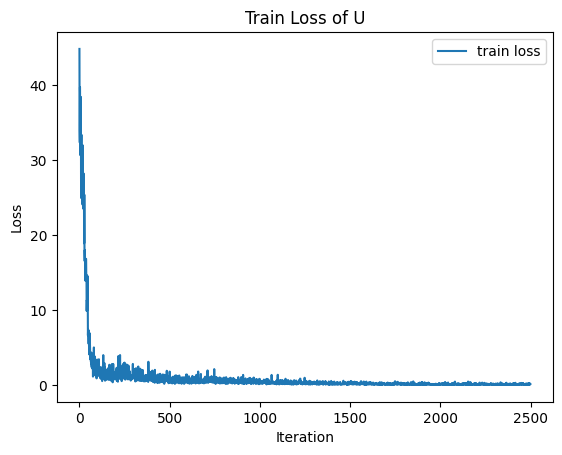

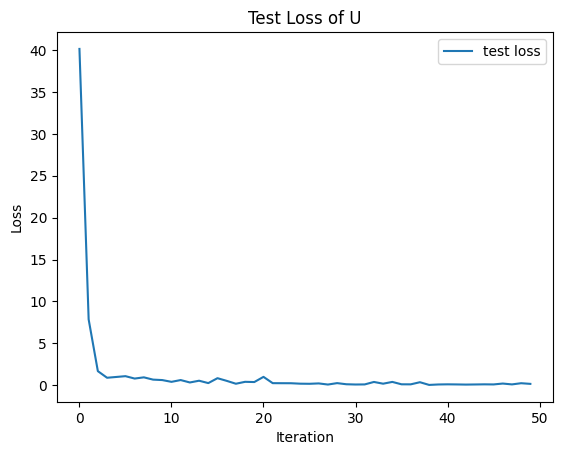

In [7]:
u_net = Net(48)
u_loss_hist, u_test_loss_hist = train(u_dataset, "U", u_net)

plt.plot(u_loss_hist,label='train loss')
plt.title("Train Loss of U")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('/kaggle/working/u_train_loss.png')
plt.show()

plt.plot(u_test_loss_hist,label='test loss')
plt.title("Test Loss of U")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('/kaggle/working/u_test_loss.png')
plt.show()

training on cuda------
------Epoch 1, Iteration 0------
------Loss of Str 为：26.878559112548828------
------Epoch 1, Iteration 50------
------Loss of Str 为：8.70612621307373------
------Epoch 1, Iteration 100------
------Loss of Str 为：18.75739288330078------
------Epoch 1, Iteration 150------
------Loss of Str 为：5.097693920135498------
------Epoch 1, Iteration 200------
------Loss of Str 为：8.311004638671875------
------Epoch 2, Iteration 0------
------Loss of Str 为：2.835353136062622------
------Epoch 2, Iteration 50------
------Loss of Str 为：3.050151824951172------
------Epoch 2, Iteration 100------
------Loss of Str 为：2.950406074523926------
------Epoch 2, Iteration 150------
------Loss of Str 为：3.0533604621887207------
------Epoch 2, Iteration 200------
------Loss of Str 为：1.5969109535217285------
------Epoch 3, Iteration 0------
------Loss of Str 为：1.5531474351882935------
------Epoch 3, Iteration 50------
------Loss of Str 为：2.7019338607788086------
------Epoch 3, Iteration 100------

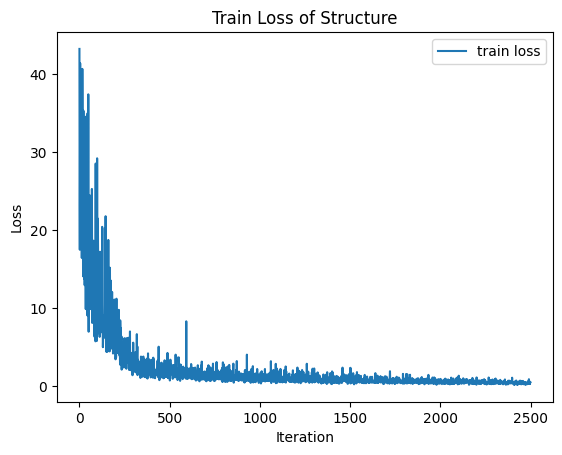

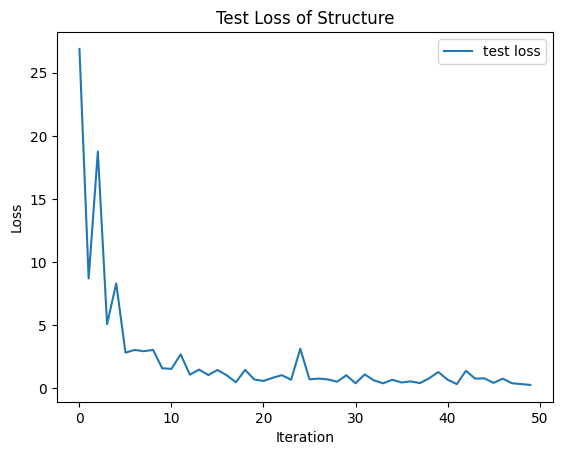

In [8]:
# lr=0.002
# num_hidden = 150
str_net = Net(480)
str_loss_hist, str_test_loss_hist = train(str_dataset, 'Str', str_net)
plt.plot(str_loss_hist,label='train loss')
plt.title("Train Loss of Structure")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('/kaggle/working/str_train_loss.png')
plt.show()

plt.plot(str_test_loss_hist,label='test loss')
plt.title("Test Loss of Structure")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('/kaggle/working/str_test_loss.png')
plt.show()

In [9]:


def differencetest(tag, model, rdata):
    area_diff = []
    L1loss = []
    L2loss = []
    diff = []
    test_net = model
    
    num_plot = 5440 - split
    for index in range(30):
        test_seq_tag = sequence[index+split]
        test_label = ''.join([str(j) for j in test_seq_tag if j != 0.5])
        test_seq_tag = torch.tensor(test_seq_tag, dtype=dtype)
        test_seq_tag = test_seq_tag.to(device)
        test_net.eval()
        mem = test_net(test_seq_tag)
        mem = mem.cpu().detach().numpy()

        pred_tag = mem[-1]
        if tag == 'Str':
            pred_tag = [item / ratio for item in pred_tag]
            rdata[index][20:] /= ratio
        
        
        diff = pred_tag - rdata[index][20:].cpu().detach().numpy()
        diff = [abs(x) for x in diff]
        diff2 = [x**2 for x in diff]
        length = len(diff)
        L1loss.append(sum(diff))
        L2loss.append(sum(diff2))
        area_diff.append(integrate.trapezoid(diff, range(length)))

#     max_diff = np.max(area_diff) - np.min(area_diff)
#     area_diff = [float(x - np.min(area_diff)) / max_diff for x in area_diff]
#     area_diff = np.array(area_diff)
#     mean_val = np.mean(area_diff)
#     std_val = np.std(area_diff)
#     area_diff = [(x - mean_val) / std_val for x in area_diff]
    return area_diff, L1loss, L2loss

In [10]:
import random
from scipy import integrate


# 计算目标值和预测值的差值
def difference(tag, model, rdata):
    area_diff = []
    diff = []
    test_net = model
    
    # 预测的数据量
    num_plot = 5440 - split
    
    for index in range(num_plot):
        # 预测
        test_seq_tag = sequence[index+split]
        test_label = ''.join([str(j) for j in test_seq_tag if j != 0.5])
        test_seq_tag = torch.tensor(test_seq_tag, dtype=dtype)
        test_seq_tag = test_seq_tag.to(device)
        test_net.eval()
        mem = test_net(test_seq_tag)
        mem = mem.cpu().detach().numpy()

        pred_tag = mem[-1]
        # 还原数据
        if tag == 'Str':
            pred_tag = [item / ratio for item in pred_tag]
            rdata[index][20:] /= ratio
        if index < 20:
            plt.plot(rdata[index][20:], label='target')
            plt.plot(pred_tag, label='output')
            plt.title(str(test_label))
            plt.legend()
            plt.xlabel("z")
            plt.ylabel(tag)
            plt.savefig('/kaggle/working/' + tag + '_' + str(index) + '.png')
            plt.show()
        
        # 计算差值
        diff = pred_tag - rdata[index][20:].cpu().detach().numpy()
        diff = [abs(x) for x in diff]
        length = len(diff)
        area_diff.append(integrate.trapezoid(diff, range(length)))

#     max_diff = np.max(area_diff) - np.min(area_diff)
#     area_diff = [float(x - np.min(area_diff)) / max_diff for x in area_diff]
#     area_diff = np.array(area_diff)
#     mean_val = np.mean(area_diff)
#     std_val = np.std(area_diff)
#     area_diff = [(x - mean_val) / std_val for x in area_diff]
    plt.plot(area_diff)
    plt.title("Difference between output and target")
    plt.xlabel("index")
    plt.ylabel("area_diff")
    plt.savefig('/kaggle/working/myplot_' + tag + '.png')
    plt.show()
    return area_diff

In [11]:
# areaf,l1lossf, l2lossf= differencetest('F',f_net,f_test)
# plt.plot(areaf[:20], label='integrate')
# plt.plot(l1lossf[:20], label='L1-loss')
# plt.plot(l2lossf[:20], label='L2-loss')
# plt.title("Difference between output and target")
# plt.legend()
# plt.xlabel("index")
# plt.ylabel("area_diff")
# # plt.savefig('/kaggle/working/myplot_' + tag + '.png')
# plt.show()

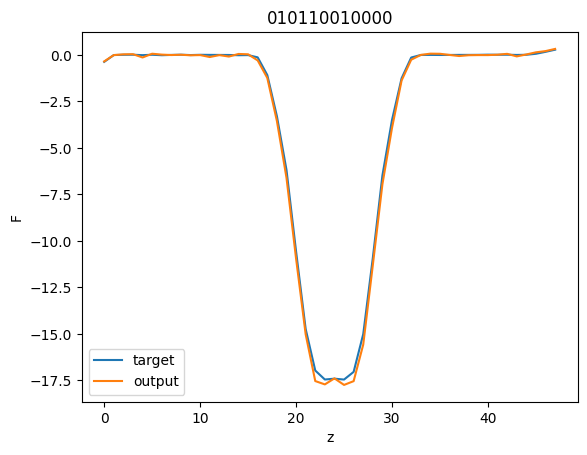

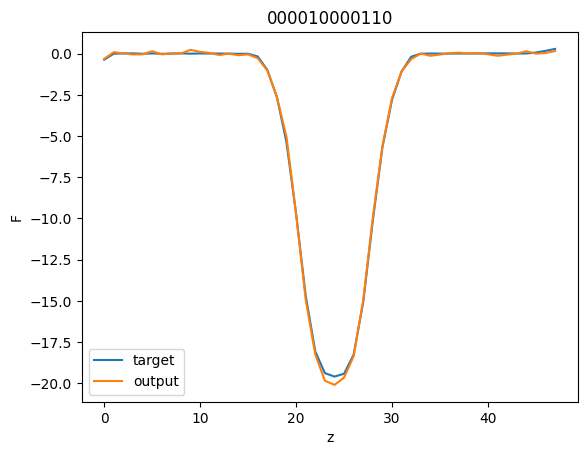

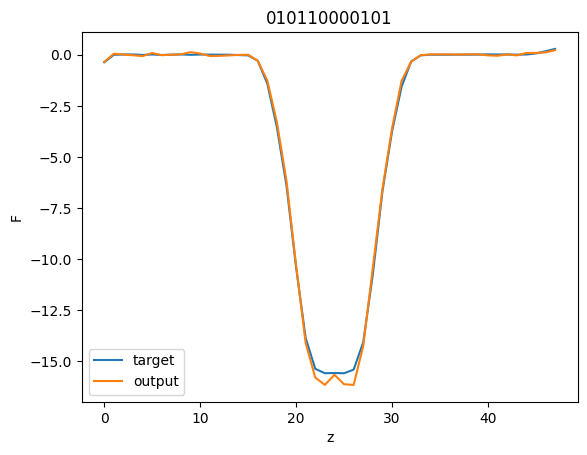

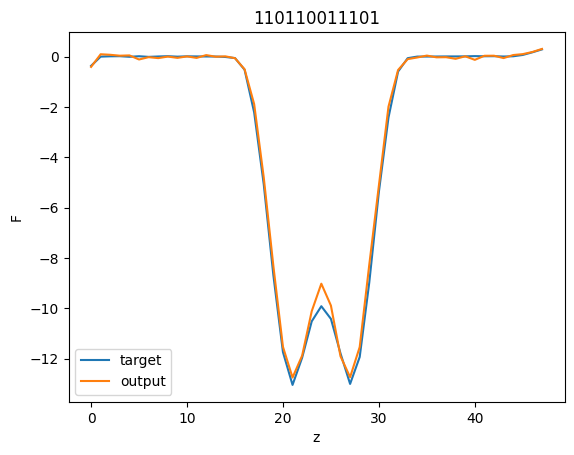

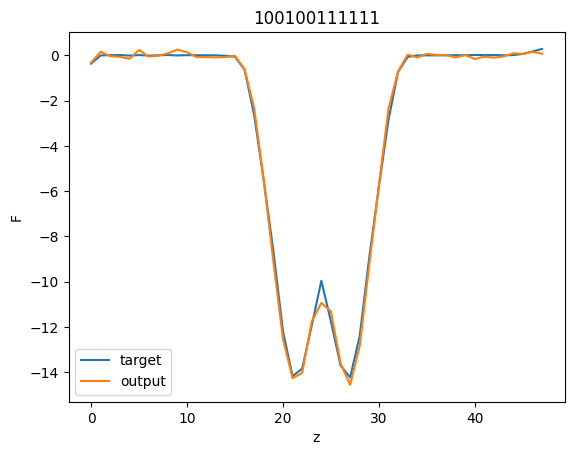

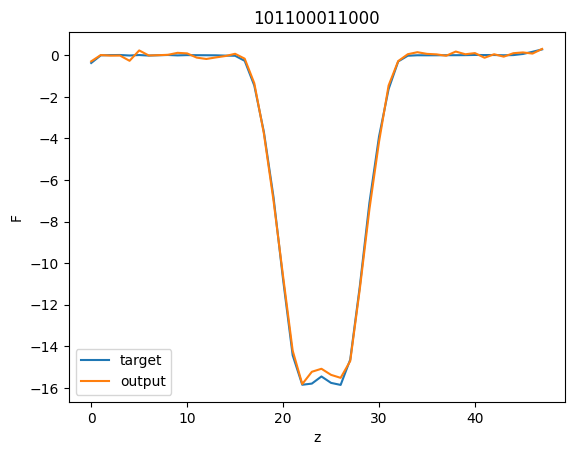

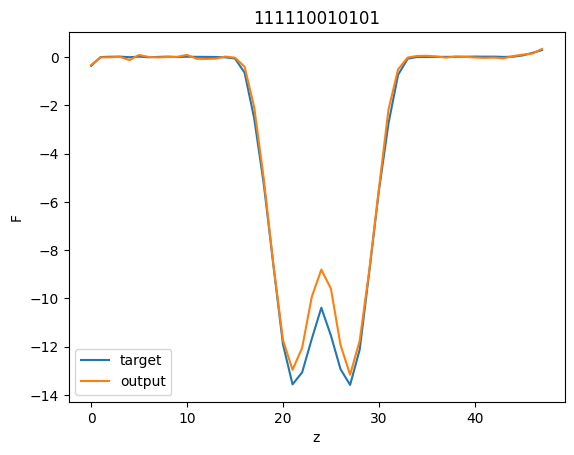

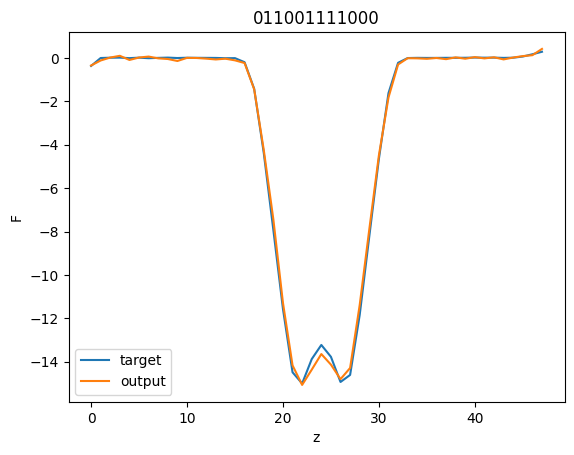

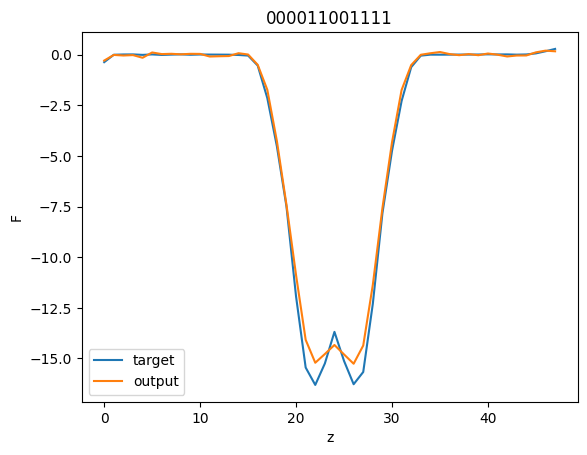

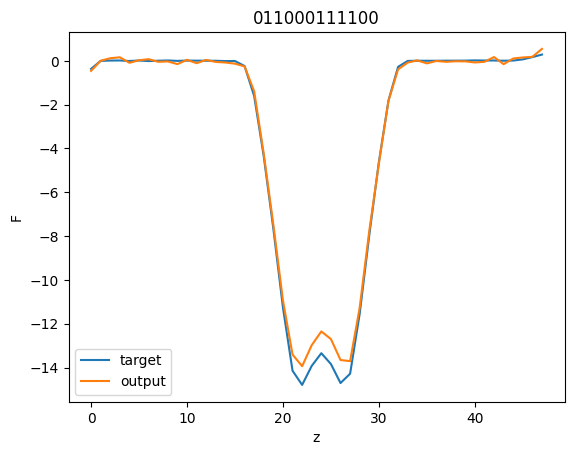

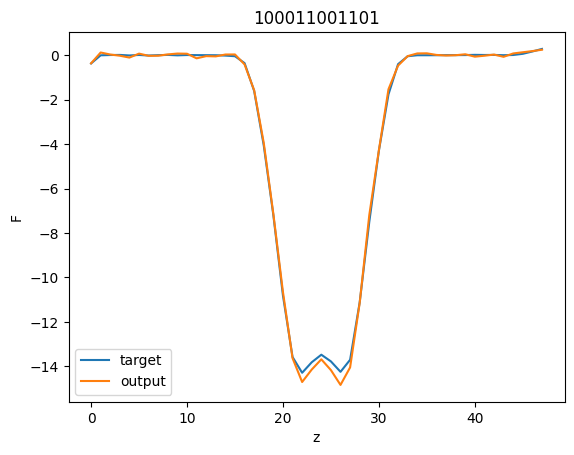

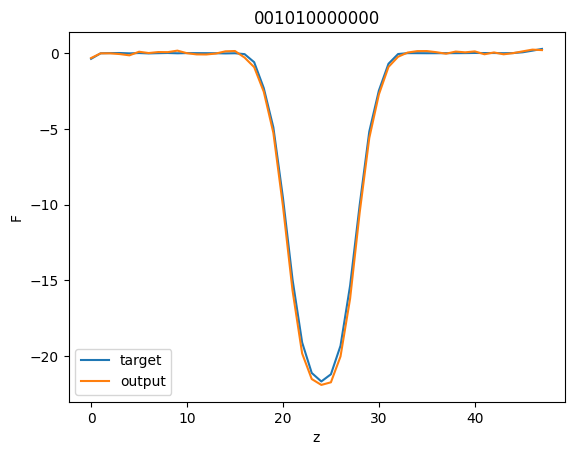

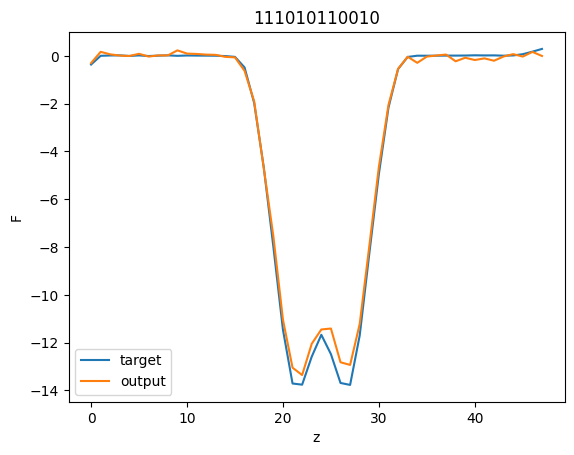

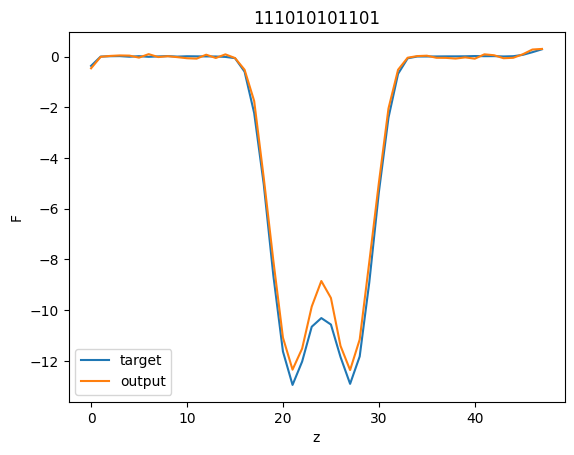

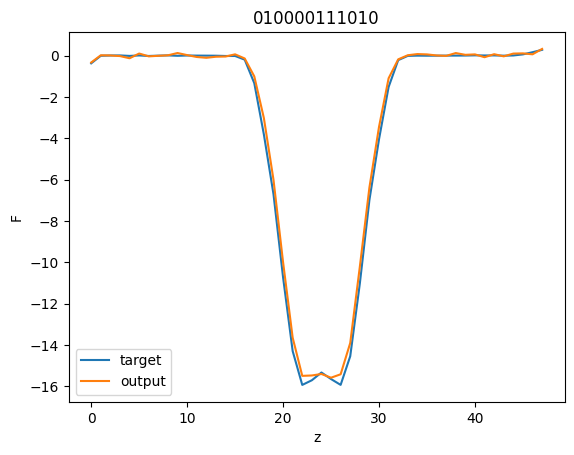

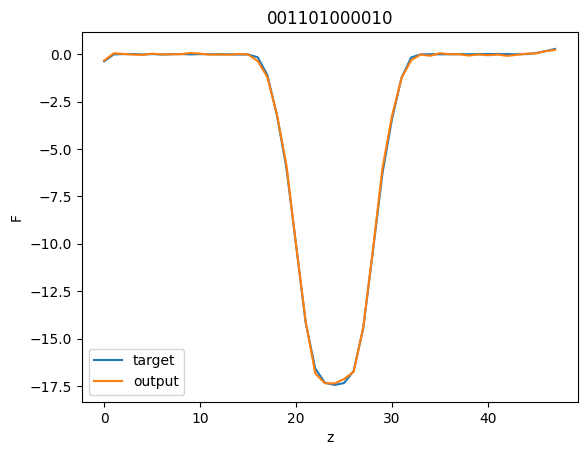

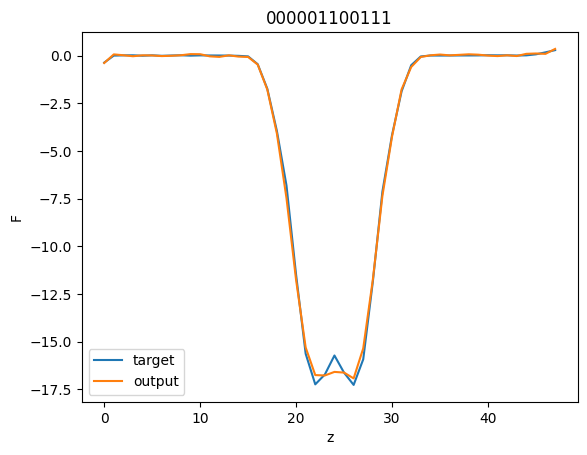

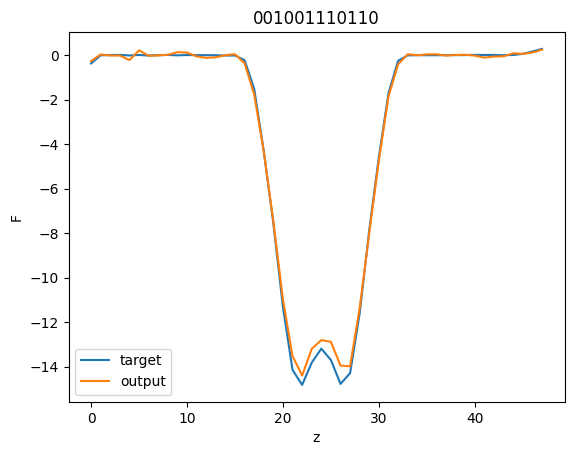

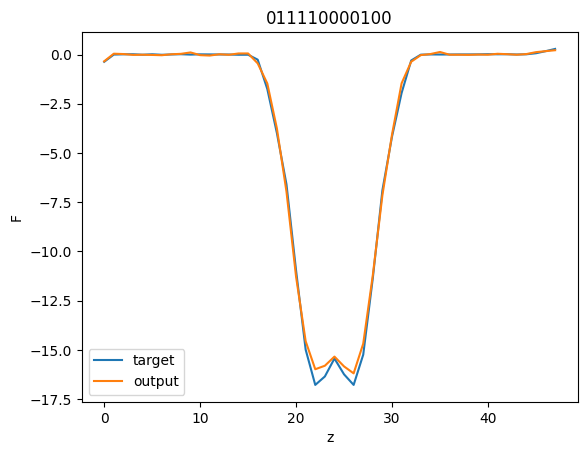

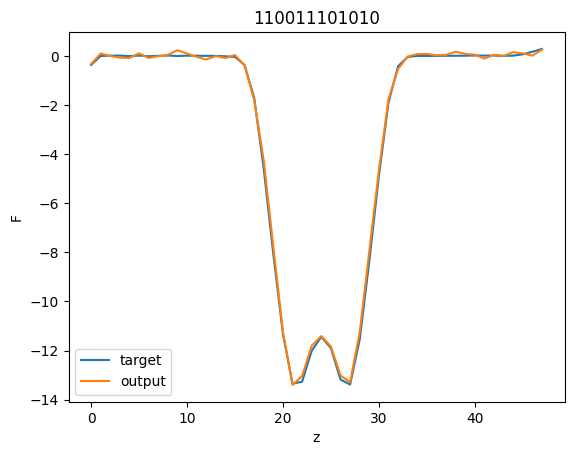

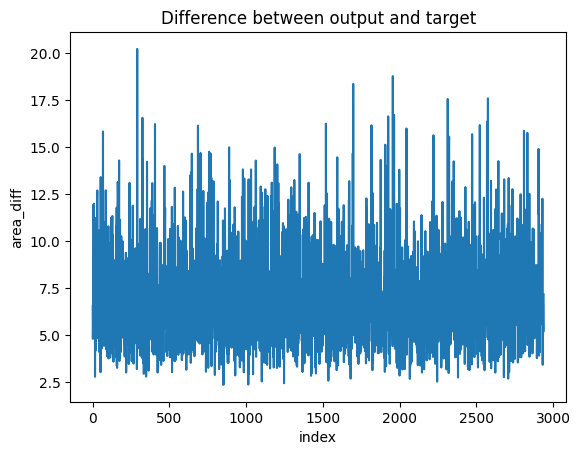

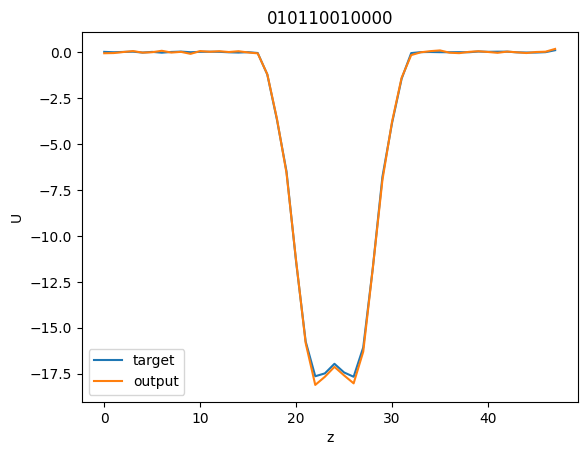

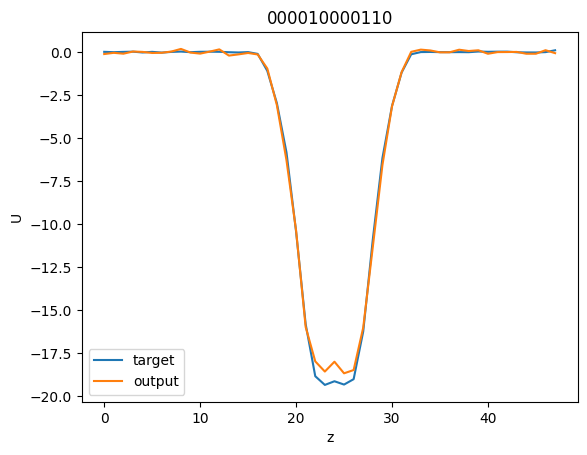

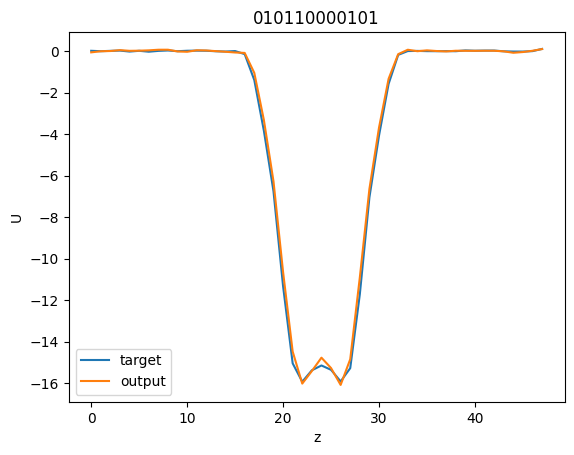

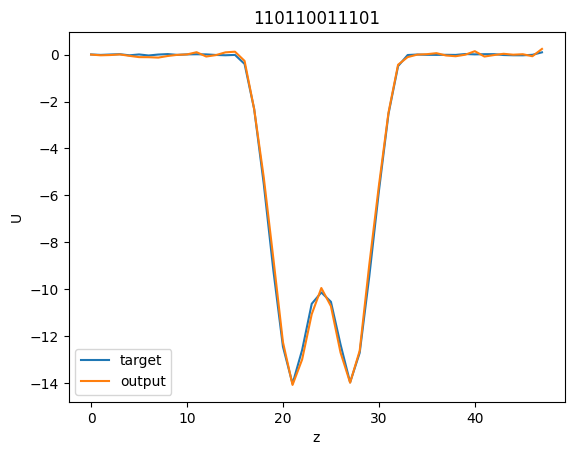

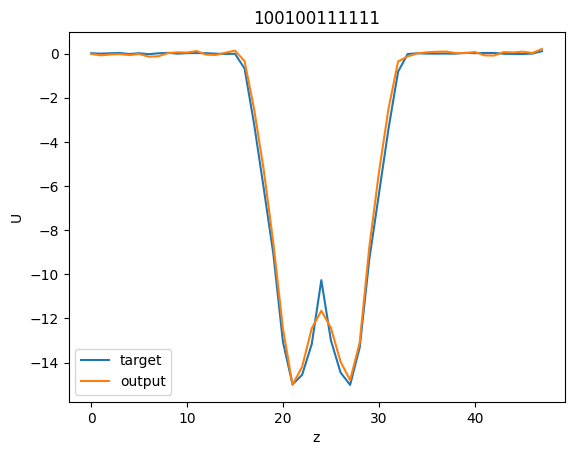

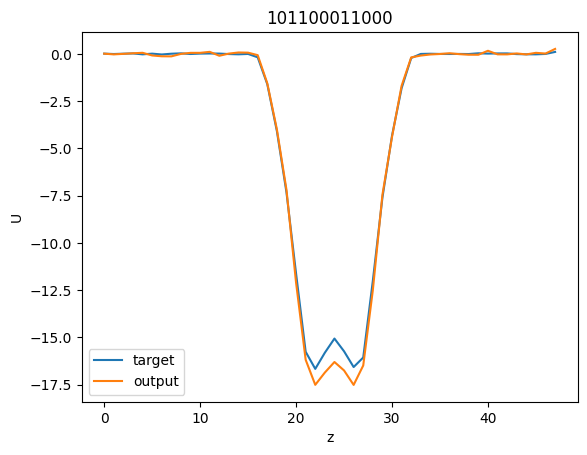

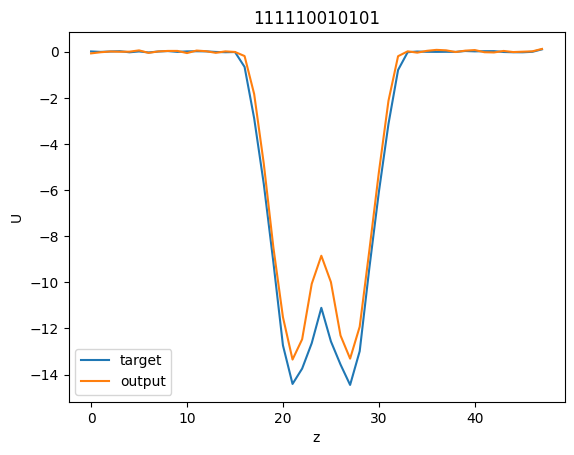

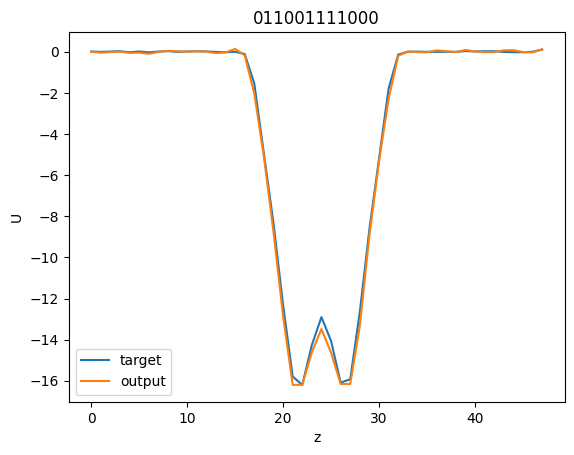

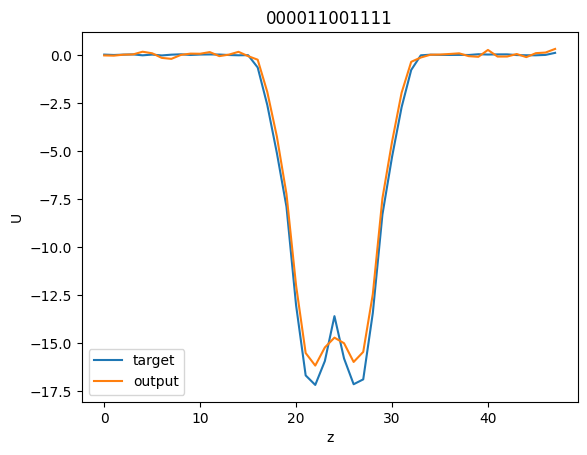

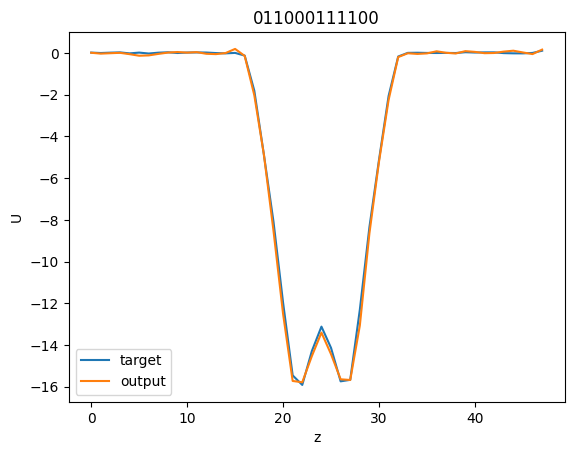

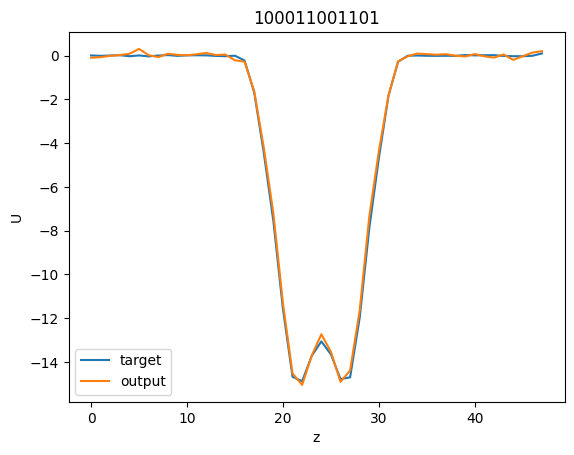

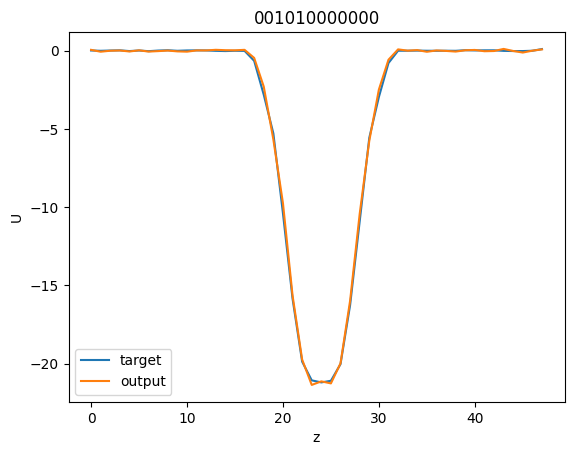

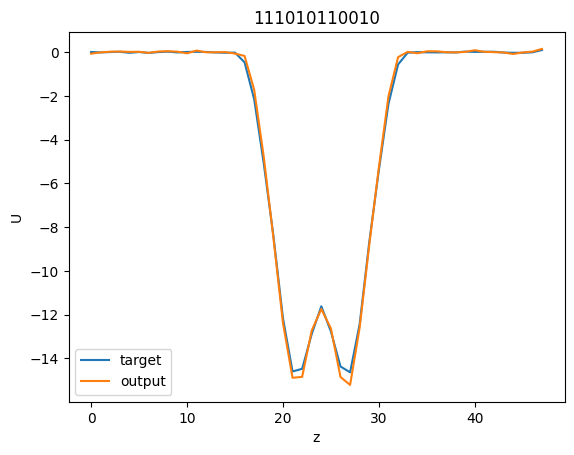

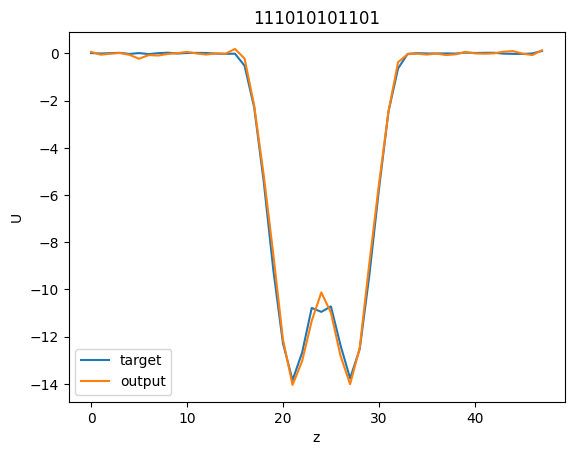

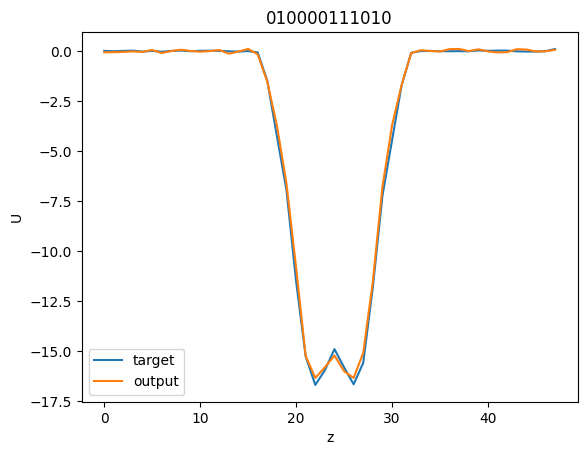

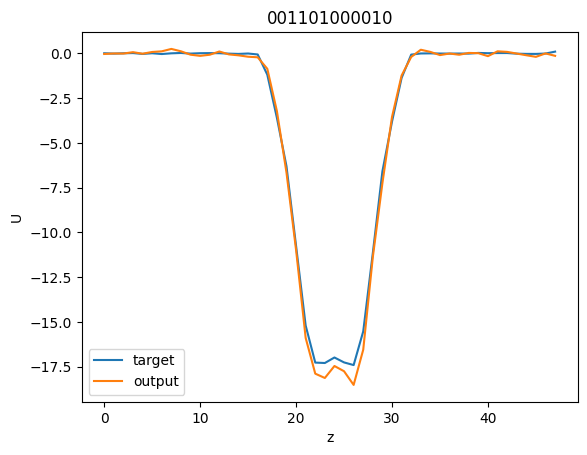

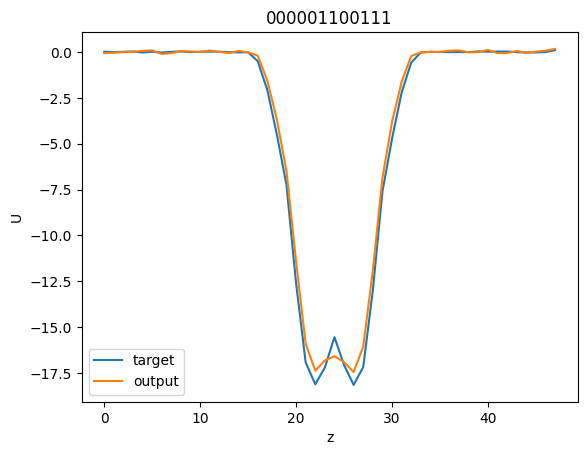

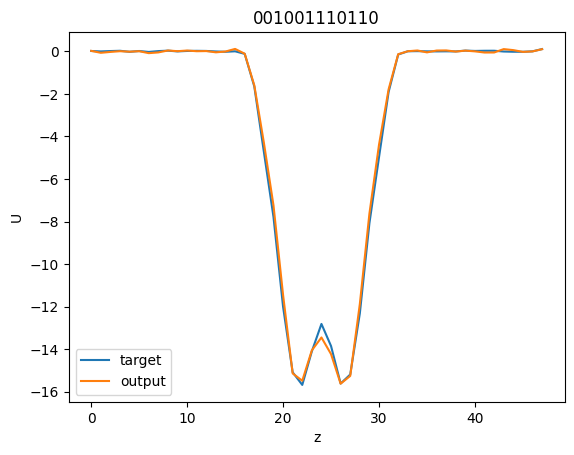

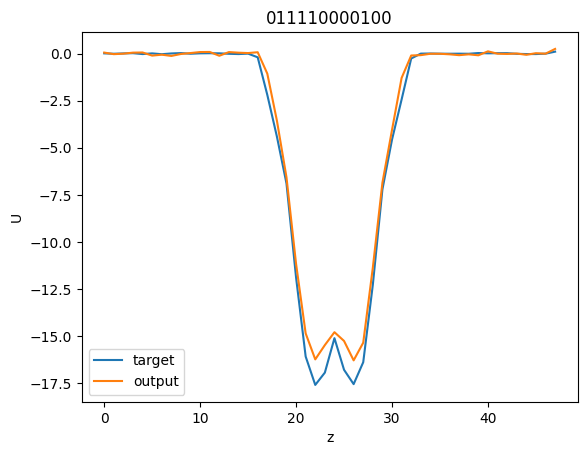

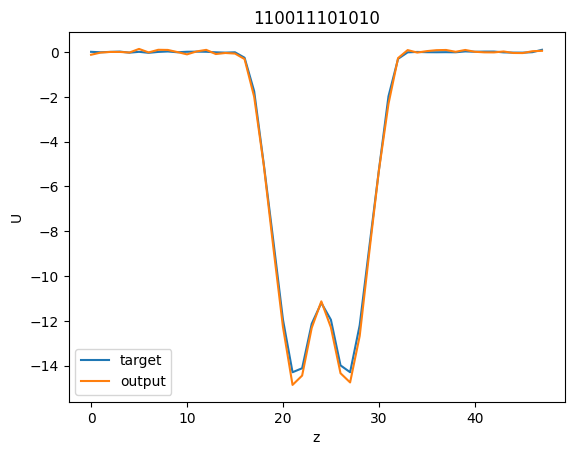

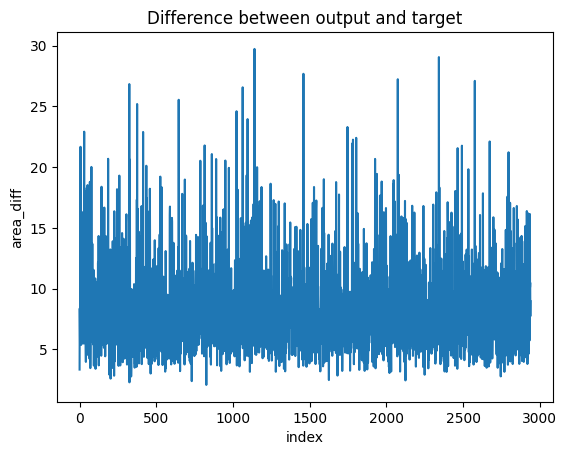

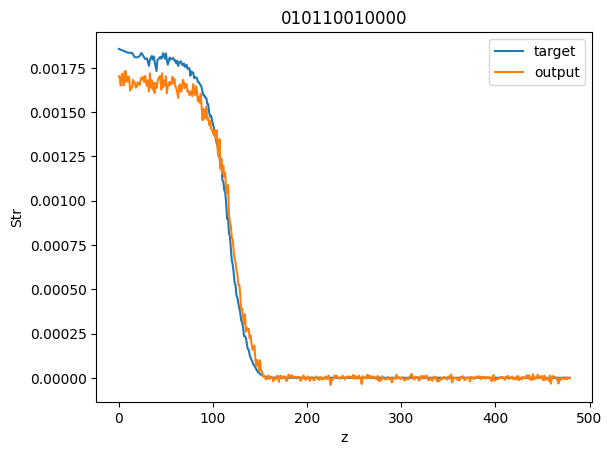

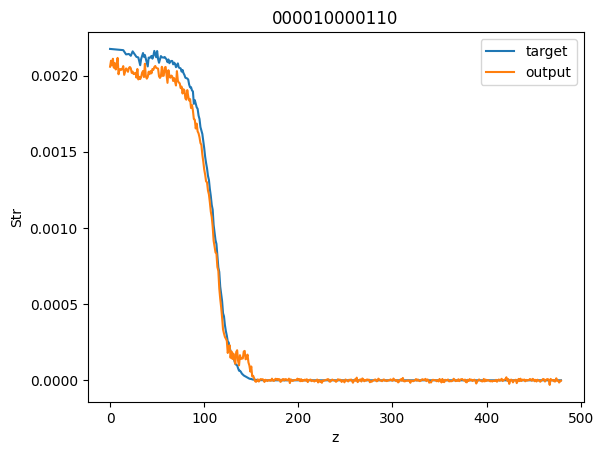

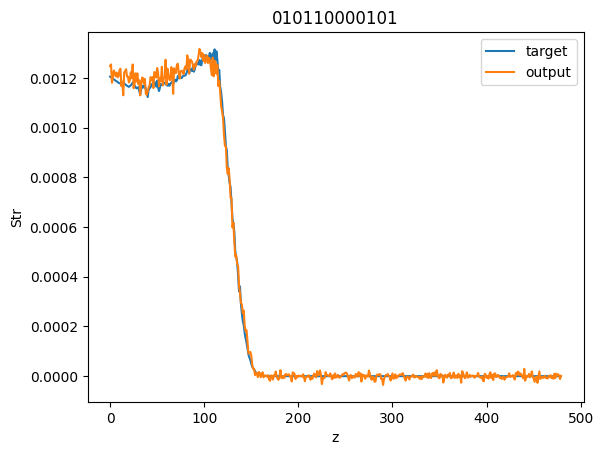

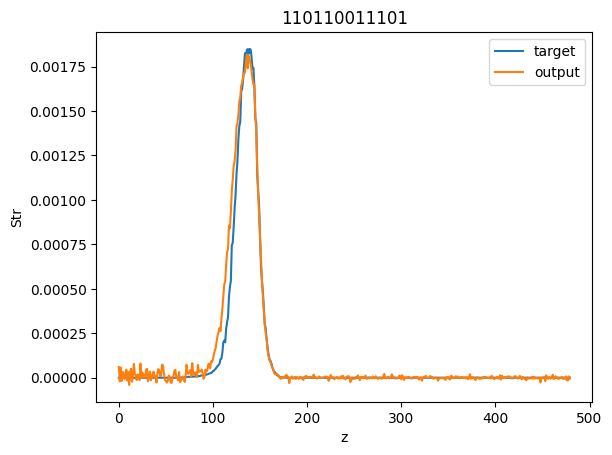

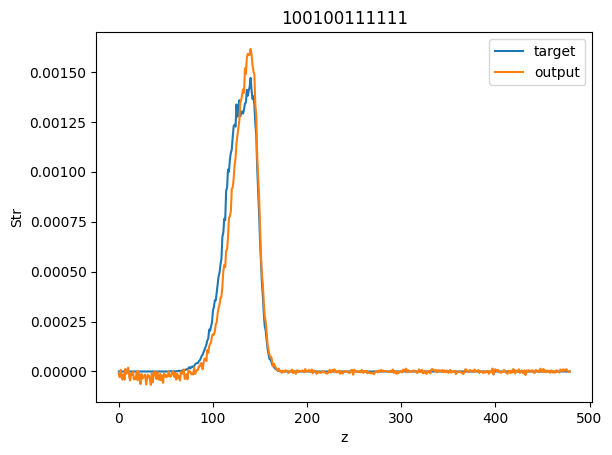

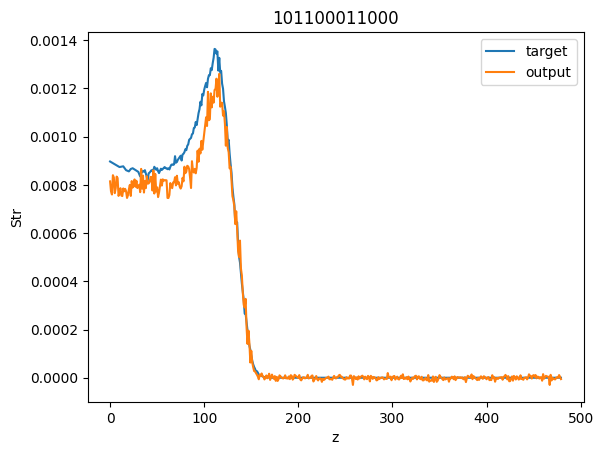

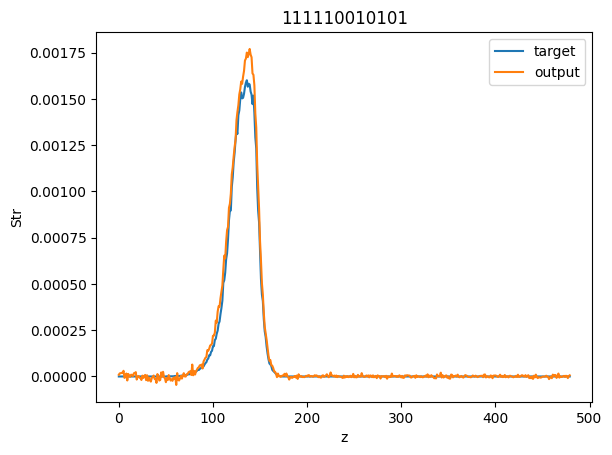

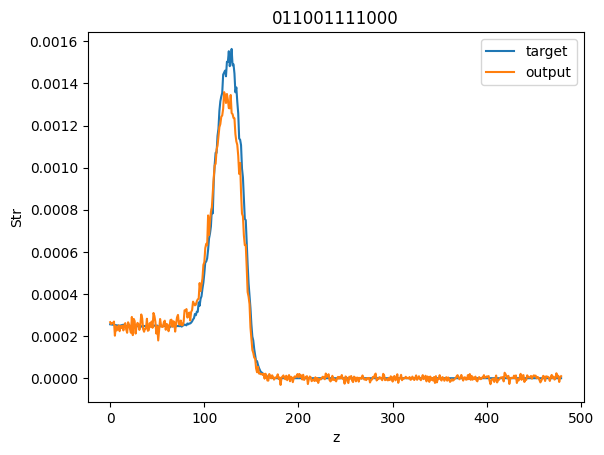

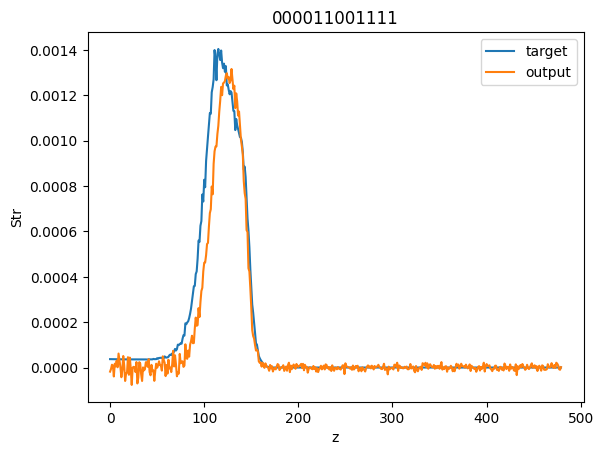

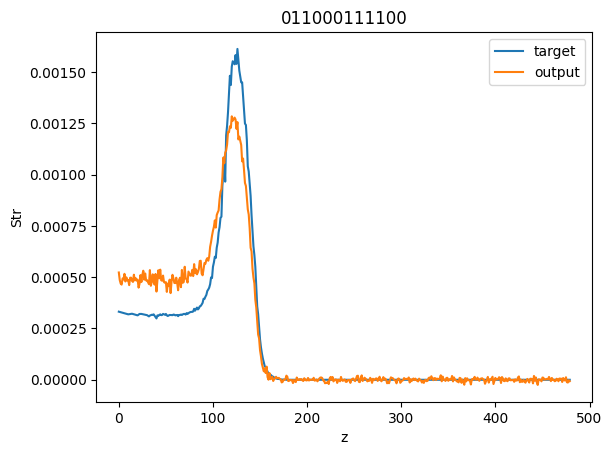

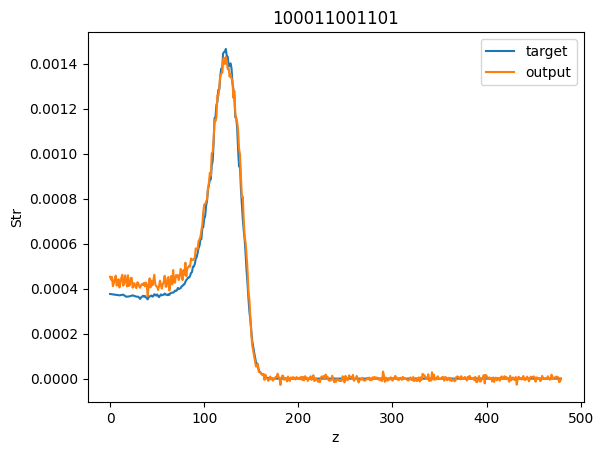

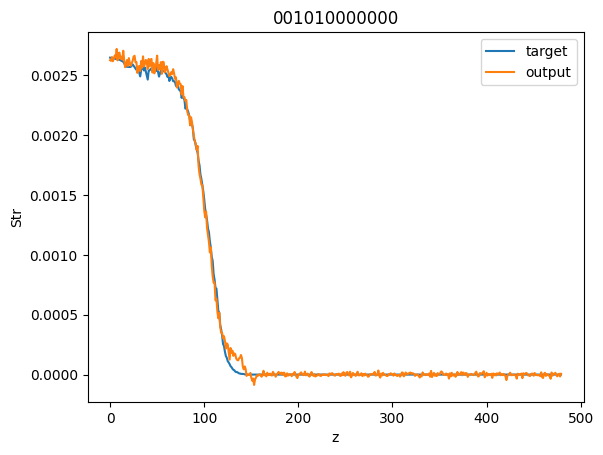

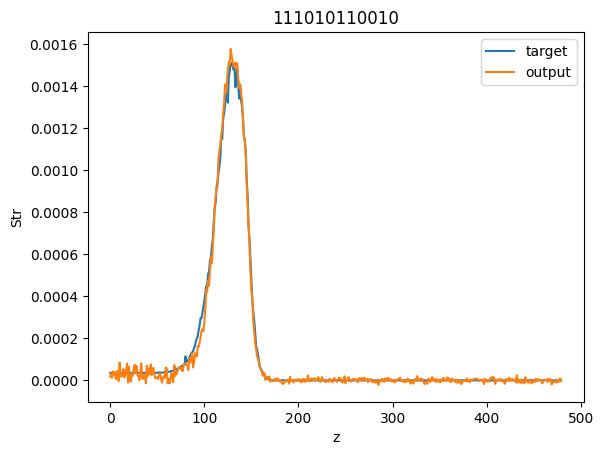

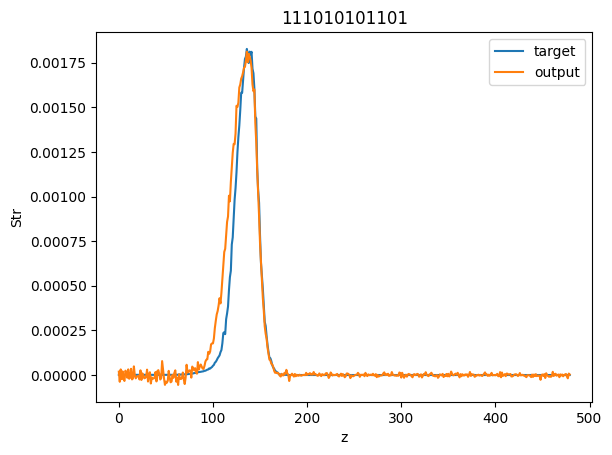

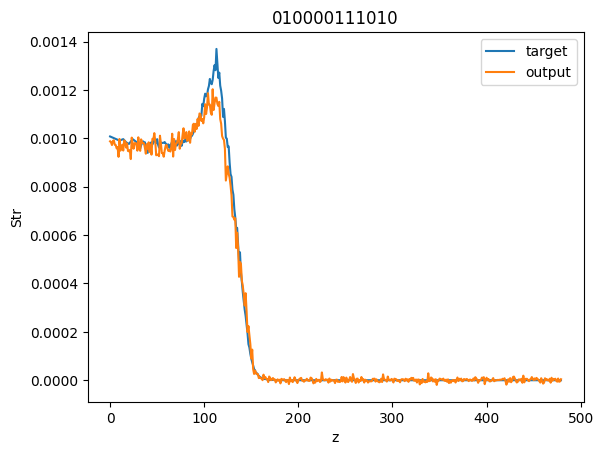

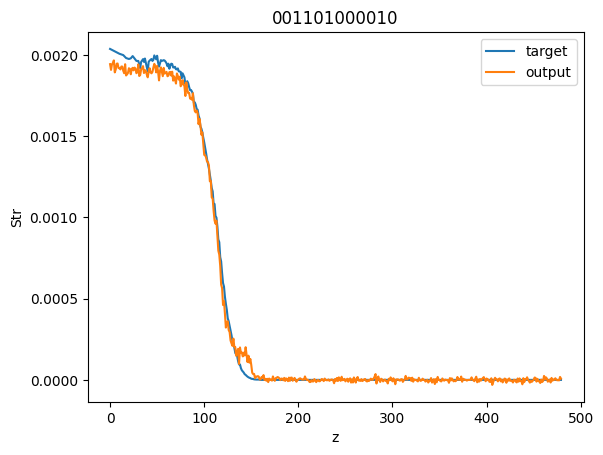

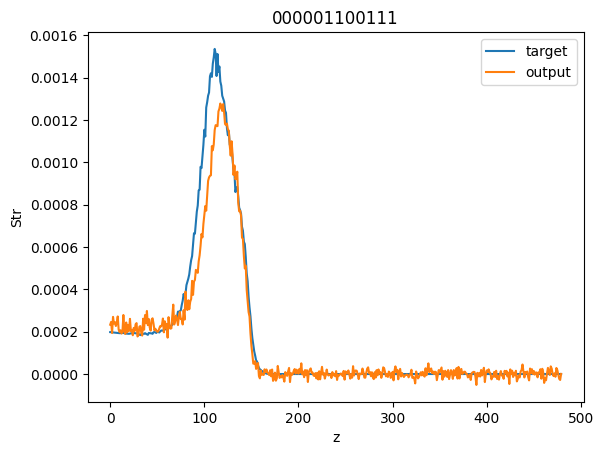

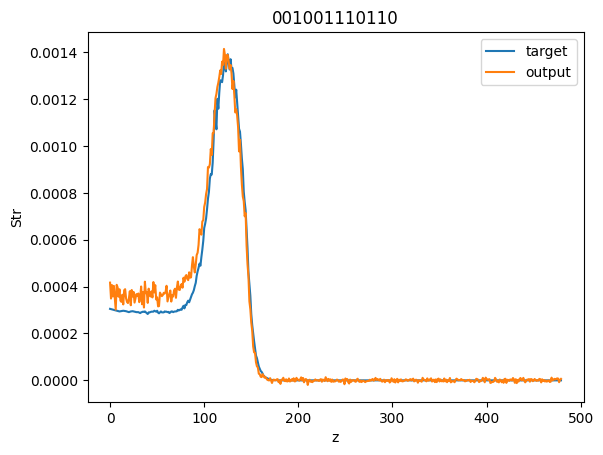

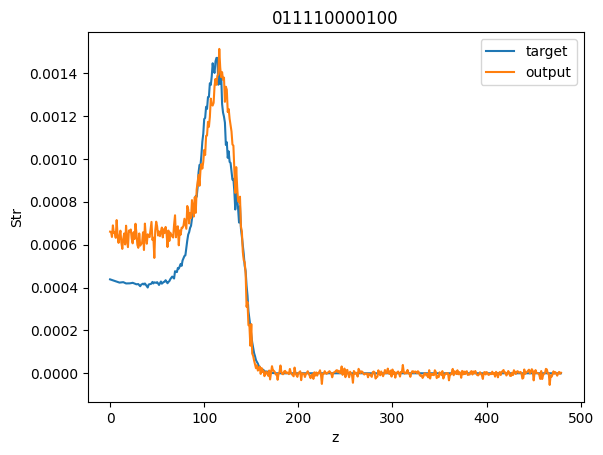

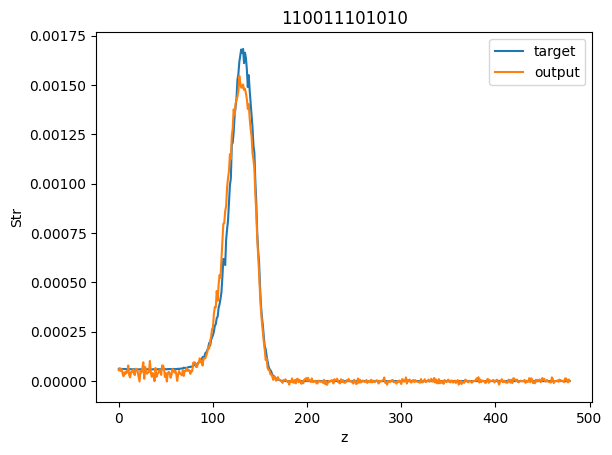

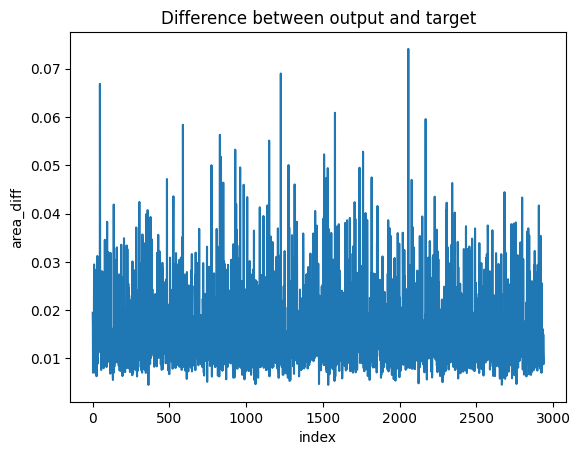

In [12]:
df = pd.DataFrame(columns=['F', 'U', 'Str'])
df['F'] = difference('F', f_net, f_test)
df['U'] = difference('U', u_net, u_test)
df['Str'] = difference('Str', str_net, str_test)
df.to_csv('/kaggle/working/diff.csv', index=False)

In [13]:
np.mean(df['F'])

6.87102706325875

In [14]:
np.mean(df['U'])

8.192557202569853

In [15]:
np.mean(df['Str'])

0.01602841187364533

In [16]:
a,b,c = np.mean(df['F']),np.mean(df['U']),np.mean(df['Str'])
a1,b1,c1 = 3.1558,3.2971,2.2560e-4
r1=a/a1/48
r2=b/b1/48
r3=c/c1/480
print("F的相对误差：{:.4%}".format(r1))
print("U的相对误差{:.4%}".format(r2))
print("Str的相对误差{:.4%}".format(r3))

F的相对误差：4.5360%
U的相对误差5.1766%
Str的相对误差14.8017%
